<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Комментарий-ревьювера" data-toc-modified-id="Комментарий-ревьювера-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Комментарий ревьювера</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Тренд-и-сезонность" data-toc-modified-id="Тренд-и-сезонность-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Тренд и сезонность</a></span></li><li><span><a href="#Стационарный-ряд" data-toc-modified-id="Стационарный-ряд-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Стационарный ряд</a></span></li><li><span><a href="#Разность-временного-ряда" data-toc-modified-id="Разность-временного-ряда-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Разность временного ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Наша задача - построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [32]:
!pip install catboost

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostRegressor

from time import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

RS = 52

## Знакомство с данными и предобработка

In [34]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

display(data.head(), data.tail())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Проверили на дубликаты:

In [36]:
print(data.duplicated().sum())

0


Привели данные к формату datetime. Отсортировали и сделали столбец с датой индексом:

In [37]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data['datetime'] = data['datetime'].sort_values().reset_index(drop=True)
data = data.set_index(['datetime'])
data.dtypes

num_orders    int64
dtype: object

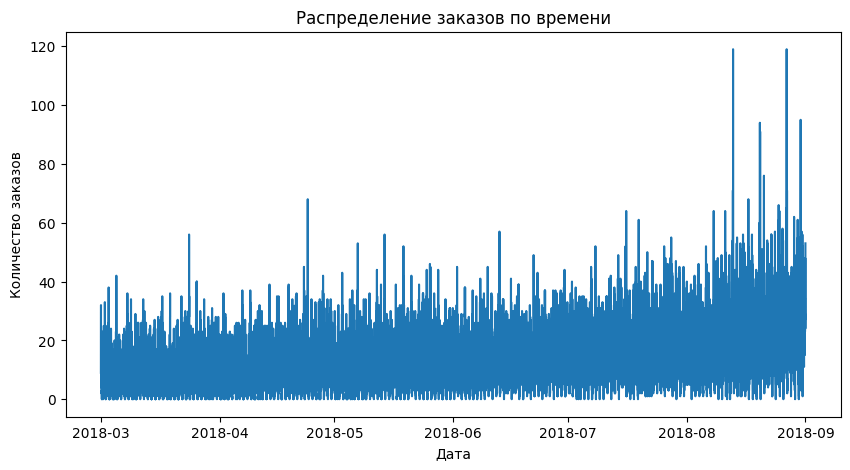

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(data['num_orders'])
plt.title('Распределение заказов по времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Провели ресемплирование по часу.

In [39]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


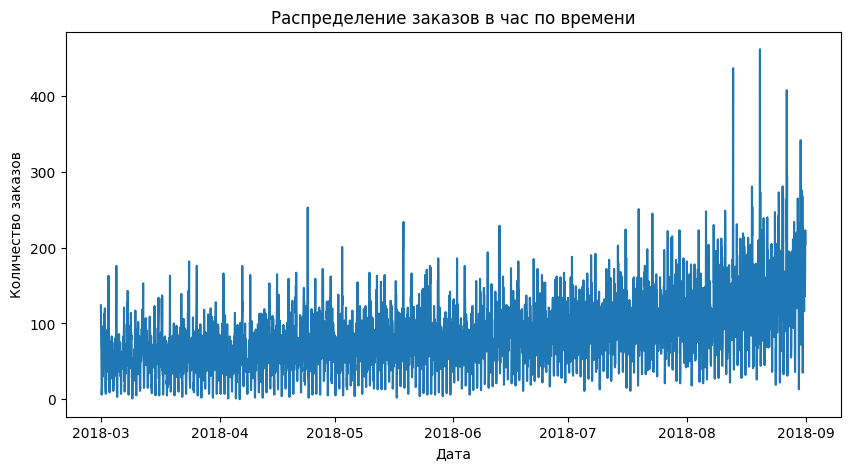

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(data)
plt.title('Распределение заказов в час по времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Приблизили график:

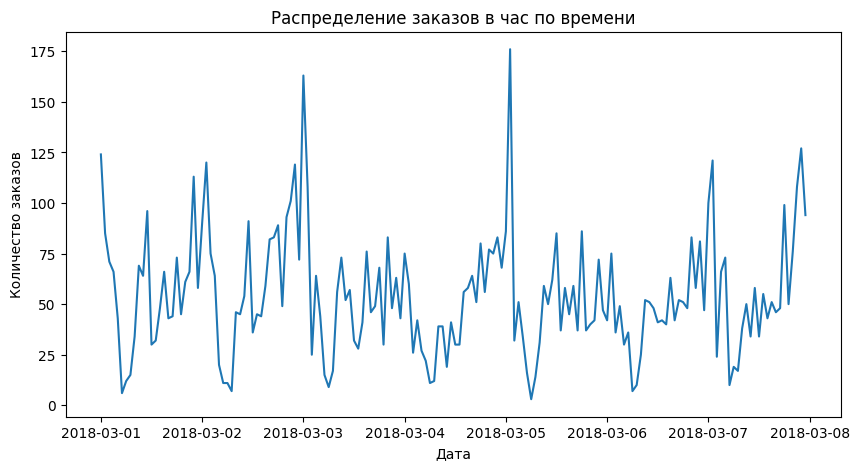

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(data['2018-03-01':'2018-03-07'])
plt.title('Распределение заказов в час по времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

## Анализ

### Скользящее среднее

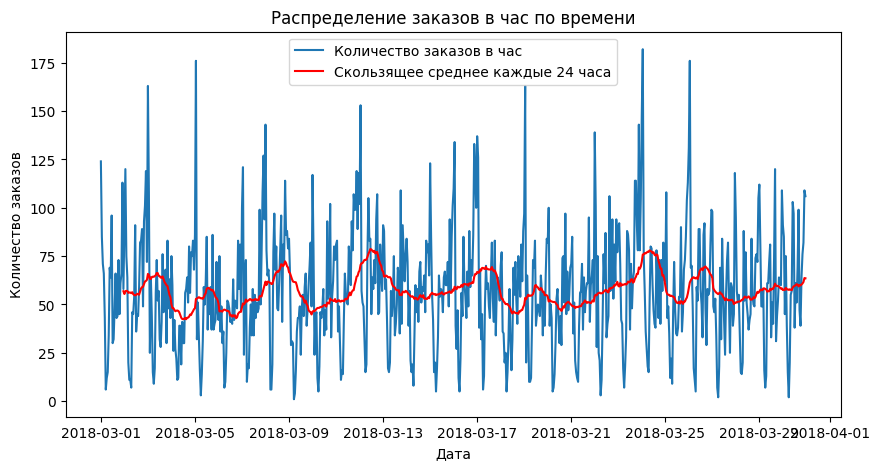

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(data['2018-03-01':'2018-03-30'])
plt.plot(data['2018-03-01':'2018-03-30'].rolling(24).mean(), color='red')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

### Тренд и сезонность

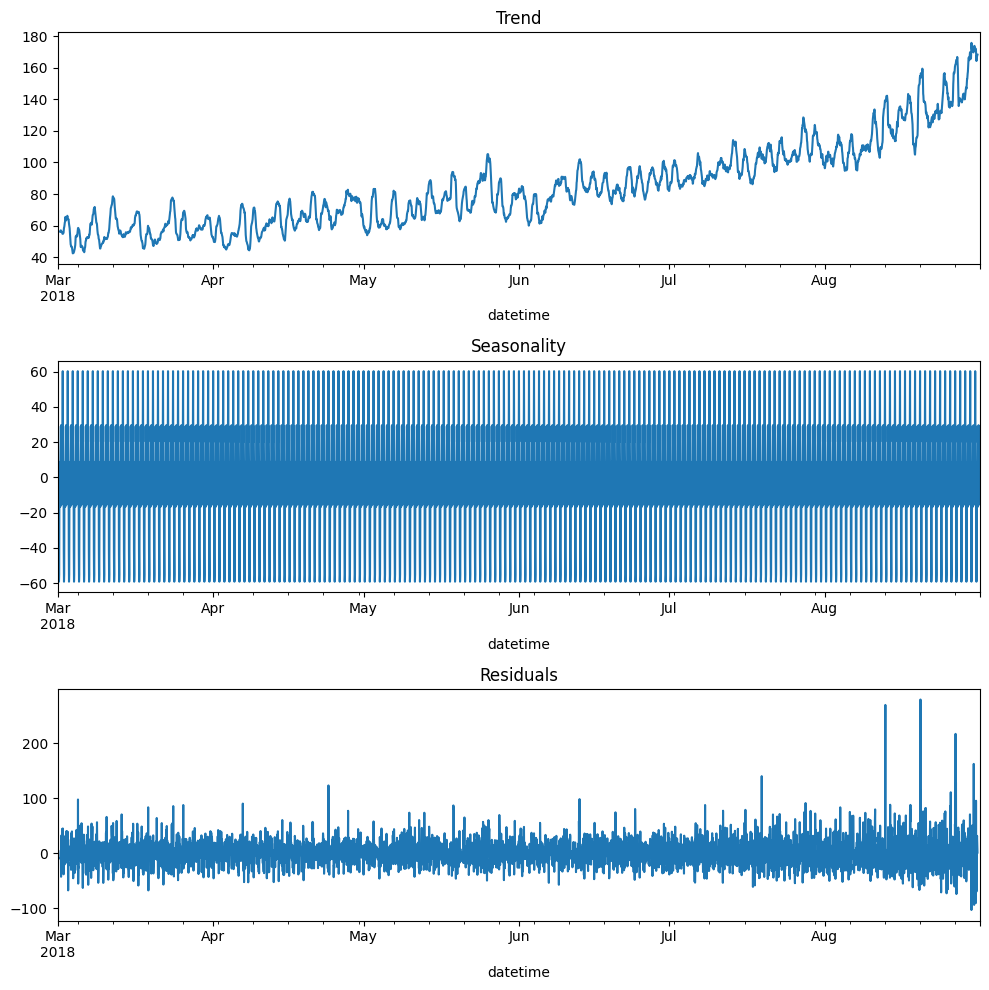

In [43]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 10))
plt.subplot(311)
"""
Чтобы график корректно отобразился, указываем его
оси ax, равными plt.gca() (англ. get current axis,
получить текущие оси)
"""
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

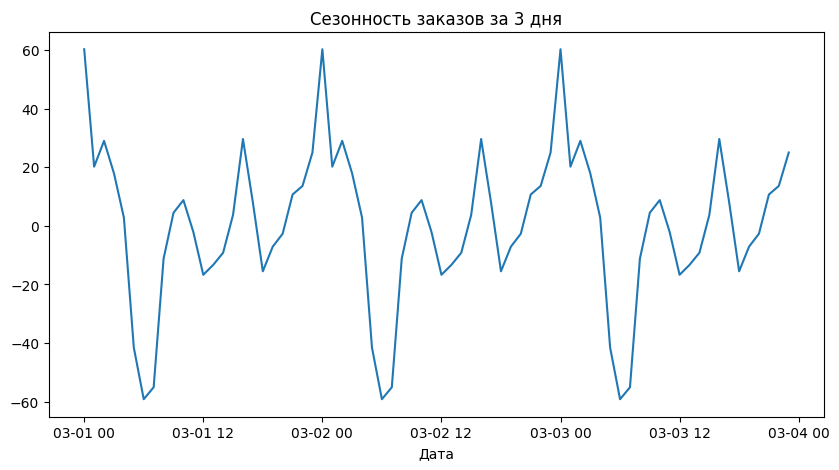

In [44]:
plt.figure(figsize=(10,5))
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-3'])
plt.title('Сезонность заказов за 3 дня')
plt.xlabel('Дата')
plt.show()

**Вывод:**

- Тренд - количество заказов увеличивается. С чем это связано, говорить нельзя так как данные представлены лишь за полгода.
- Сезонность - минимум заказов около 6 утра, максимум около полуночи.
- Шум - количество заказов к концу лета растет, из-за чего амплитуда шума растет.

### Стационарный ряд

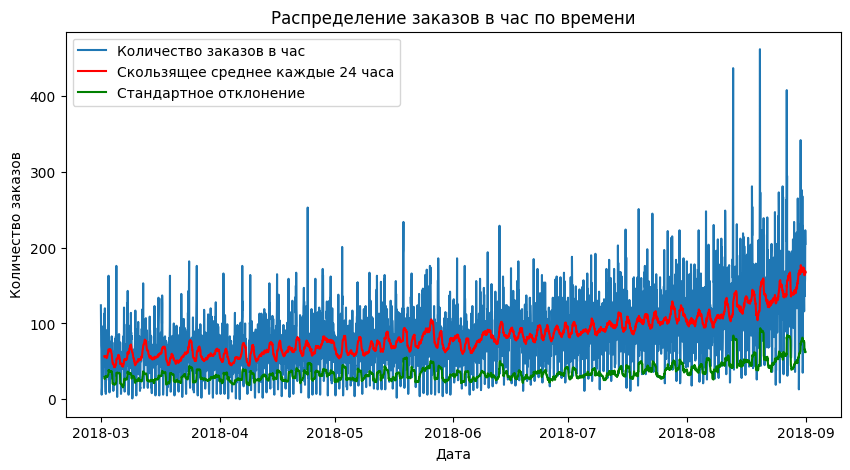

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(data)
plt.plot(data.rolling(24).mean(), color='red')
plt.plot(data.rolling(24).std(), color='green')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

В начале ряд стационарный - до 2018-06.

После 2018-06 ряд начинает меняться и становится нестационарным. Это может как повлиять на модель, так и не повлиять.

### Разность временного ряда

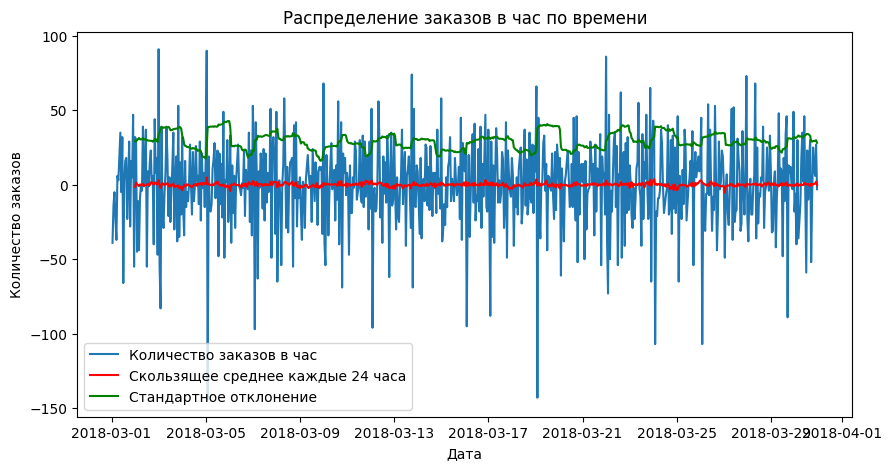

In [46]:
shift_data = data - data.shift()

plt.figure(figsize=(10, 5))
plt.plot(shift_data['2018-03-01':'2018-03-30'])
plt.plot(shift_data['2018-03-01':'2018-03-30'].rolling(24).mean(), color='red')
plt.plot(shift_data['2018-03-01':'2018-03-30'].rolling(24).std(), color='green')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()


Разности временного ряда — это набор разностей между соседними элементами временного ряда, т. е. из каждого значения вычитается предыдущее.

Как видно из полученного графика, ряд стал стационарным, то есть, если не удастся получить необходимые метрики качества, можно воспользоваться разностью временного ряда.

## Обучение

Типы признаков:

- Календарные признаки - во многих данных тренды и сезонность привязаны к конкретной дате. Тип datetime64 в Pandas уже содержит нужную информацию, осталось лишь представить её как отдельные столбцы.
- Отстающие значения - предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться.
- Скользящее среднее - скользящее среднее как признак задаёт общий тренд временного ряда.

Так как у нас идет увеличение числа заказов в течении дня - возьмём максимальное отстающее значение - 24 часа, а скользящее среднее по 6 часов, так как наблюдается, что каждые 6 часов количество заказов как растет, так и падает.

In [47]:
def new_cols(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [48]:
new_cols(data, 1, 24)
data.sample(5)

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-06-01 12:00:00,69,4,12,124.0,83.000000
2018-08-08 17:00:00,95,2,17,196.0,108.041667
2018-08-17 20:00:00,126,4,20,84.0,130.333333
2018-08-10 03:00:00,80,4,3,201.0,110.583333
2018-05-24 15:00:00,75,3,15,95.0,88.083333


Разделили данные на выборки:

In [49]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

train_X = train.drop('num_orders', axis=1)
train_y = train['num_orders']
test_X = test.drop('num_orders', axis=1)
test_y = test['num_orders']
print(train_X.shape, test_X.shape)

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00
(3950, 4) (442, 4)


Подготовили функцию для подбора гиперпараметров и сохранения результатов:

In [50]:
# создаём таблицу для анализа
analisys = pd.DataFrame({'model':[], 'RMSE_model':[], 'RMSE_on_train':[]})
all_models = []

# создаём функцию для подбора параметров
def train_model(model, parameters):

    best_rmse = 1000
    best_splits = 0
    best_model = 0

    start = time()
    for split in range(6, 25, 2):
        tscv = TimeSeriesSplit(n_splits=split)
        model_random = RandomizedSearchCV(estimator=model,
                                    param_distributions=parameters,
                                    scoring='neg_mean_absolute_error',
                                    n_jobs=-1,
                                    cv=tscv,
                                    verbose=1,
                                    random_state=RS)
        model_random.fit(train_X, train_y)
        rmse = model_random.best_score_ * -1 ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_splits = split
            best_model = model_random
    print('RandomizedSearchCV подбирал сплиты и параметры %.2f секунд' %(time() - start))
    print('Лучшие число сплитов:', best_splits)

    model_random = best_model

    # высчитаем метрики
    rmse = model_random.best_score_ * -1 ** 0.5
    rmse_on_train = mean_squared_error(train_y, model_random.predict(train_X), squared=False)

    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)
    print('RMSE на тренировочной выборке:', rmse_on_train)

    predicted = pd.DataFrame(model_random.predict(train_X), index=train_X.index)
    plt.figure(figsize=(10,5))
    plt.plot(train_y[:'2018-03-07'], color='black', alpha=0.7)
    plt.plot(predicted[:'2018-03-07'], color='red', alpha=0.7)
    plt.title('Сравнение предсказаний на трейне модели за первые 7 дней')
    plt.ylabel('Количество заказов')
    plt.xlabel('Дата')
    plt.legend(['Реальные', 'Предсказанные'])
    plt.show()

    # заполним таблицу с результатами
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, rmse_on_train])
    analisys.loc[len(analisys.index)] = row

    return model_random

Fitting 6 folds for each of 9 candidates, totalling 54 fits
Fitting 8 folds for each of 9 candidates, totalling 72 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 12 folds for each of 9 candidates, totalling 108 fits
Fitting 14 folds for each of 9 candidates, totalling 126 fits
Fitting 16 folds for each of 9 candidates, totalling 144 fits
Fitting 18 folds for each of 9 candidates, totalling 162 fits
Fitting 20 folds for each of 9 candidates, totalling 180 fits
Fitting 22 folds for each of 9 candidates, totalling 198 fits
Fitting 24 folds for each of 9 candidates, totalling 216 fits
RandomizedSearchCV подбирал сплиты и параметры 10.90 секунд
Лучшие число сплитов: 20
Лучшие параметры: {'max_depth': 7}
RMSE обученной модели: 19.724094045499477
RMSE на тренировочной выборке: 22.66158711034978


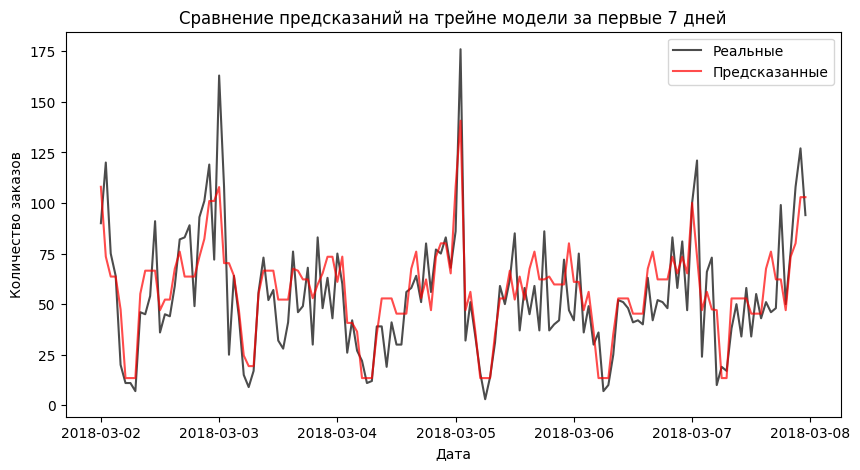

In [51]:
tree_params = {"max_depth": list(range(3, 12))}

tree = DecisionTreeRegressor(random_state=RS)

tree_model = train_model(tree, tree_params)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Fitting 8 folds for each of 10 candidates, totalling 80 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 12 folds for each of 10 candidates, totalling 120 fits
Fitting 14 folds for each of 10 candidates, totalling 140 fits
Fitting 16 folds for each of 10 candidates, totalling 160 fits
Fitting 18 folds for each of 10 candidates, totalling 180 fits
Fitting 20 folds for each of 10 candidates, totalling 200 fits
Fitting 22 folds for each of 10 candidates, totalling 220 fits
Fitting 24 folds for each of 10 candidates, totalling 240 fits
RandomizedSearchCV подбирал сплиты и параметры 535.16 секунд
Лучшие число сплитов: 22
Лучшие параметры: {'n_estimators': 100, 'max_depth': 8}
RMSE обученной модели: 17.8125208168799
RMSE на тренировочной выборке: 19.621219830041266


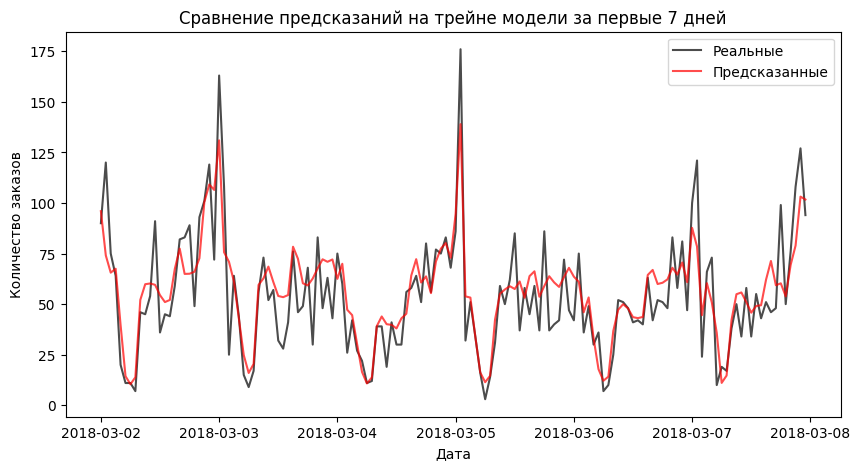

In [52]:
forest_params = {
    'max_depth': list(range(2, 9)),
    'n_estimators': [50, 100, 200, 300]
}

forest = RandomForestRegressor(n_jobs=-1, random_state=RS)

forest_model = train_model(forest, forest_params)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Fitting 8 folds for each of 10 candidates, totalling 80 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 12 folds for each of 10 candidates, totalling 120 fits
Fitting 14 folds for each of 10 candidates, totalling 140 fits
Fitting 16 folds for each of 10 candidates, totalling 160 fits
Fitting 18 folds for each of 10 candidates, totalling 180 fits
Fitting 20 folds for each of 10 candidates, totalling 200 fits
Fitting 22 folds for each of 10 candidates, totalling 220 fits
Fitting 24 folds for each of 10 candidates, totalling 240 fits
RandomizedSearchCV подбирал сплиты и параметры 75.59 секунд
Лучшие число сплитов: 24
Лучшие параметры: {'max_depth': 25, 'learning_rate': 0.1}
RMSE обученной модели: 17.372440379143285
RMSE на тренировочной выборке: 17.171760628529114


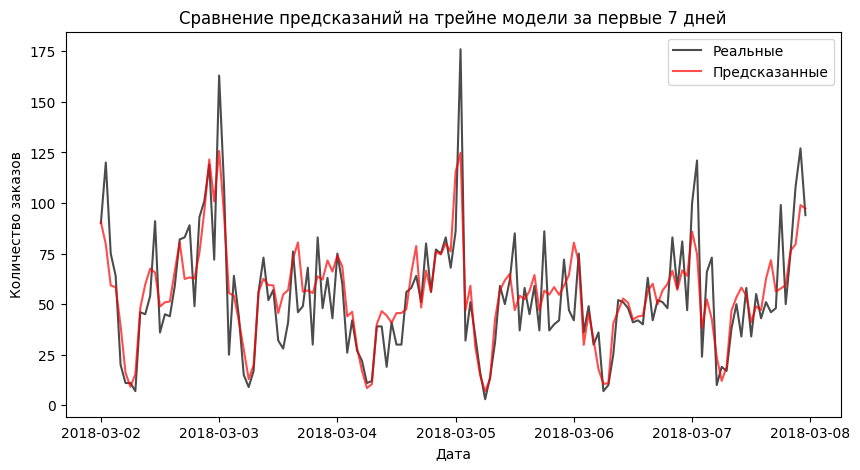

In [53]:
lgbm_param = {
    'max_depth': [5, 10, 15, 25, 35],
    'learning_rate': [0.01, 0.1, 0.15]
}

lgbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE',
                         verbose = -1,
                         random_state=RS)

lgbm_model = train_model(lgbm, lgbm_param)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Fitting 8 folds for each of 10 candidates, totalling 80 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 12 folds for each of 10 candidates, totalling 120 fits
Fitting 14 folds for each of 10 candidates, totalling 140 fits
Fitting 16 folds for each of 10 candidates, totalling 160 fits
Fitting 18 folds for each of 10 candidates, totalling 180 fits
Fitting 20 folds for each of 10 candidates, totalling 200 fits
Fitting 22 folds for each of 10 candidates, totalling 220 fits
Fitting 24 folds for each of 10 candidates, totalling 240 fits
RandomizedSearchCV подбирал сплиты и параметры 939.17 секунд
Лучшие число сплитов: 22
Лучшие параметры: {'max_depth': 4, 'learning_rate': 0.1}
RMSE обученной модели: 17.587923398071535
RMSE на тренировочной выборке: 16.557704184810706


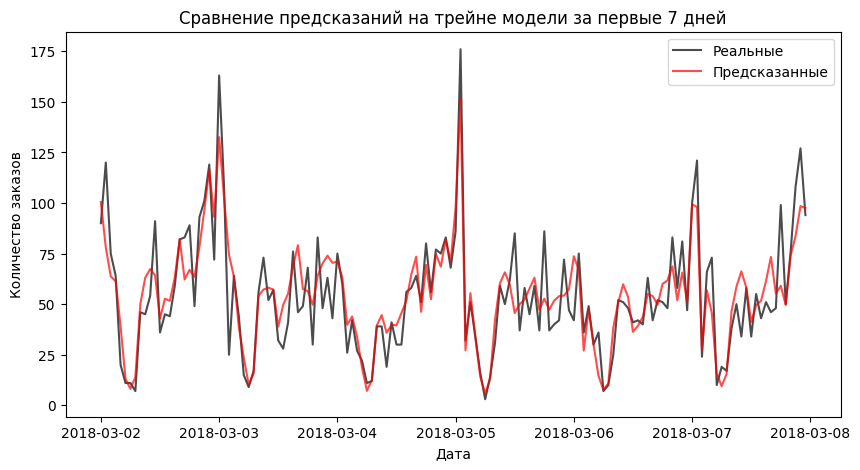

In [54]:
cat_param = {
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.1, 0.2]
}

cat = CatBoostRegressor(verbose=False,
                        random_state=RS)

cat_model = train_model(cat, cat_param)

Построили и вывели целевую метрику, которой удалось достичь по каждой модели и время, затраченное на работу модели:

,model,RMSE_model,RMSE_on_train,names
0,DecisionTreeRegressor(random_state=52),19.724094,22.661587,DecisionTree
1,"RandomForestRegressor(n_jobs=-1, random_state=52)",17.812521,19.621220,RandomForest
2,"LGBMRegressor(metric='RMSE', objective='regres...",17.372440,17.171761,LightGBM
3,<catboost.core.CatBoostRegressor object at 0x7...,17.587923,16.557704,CatBoost


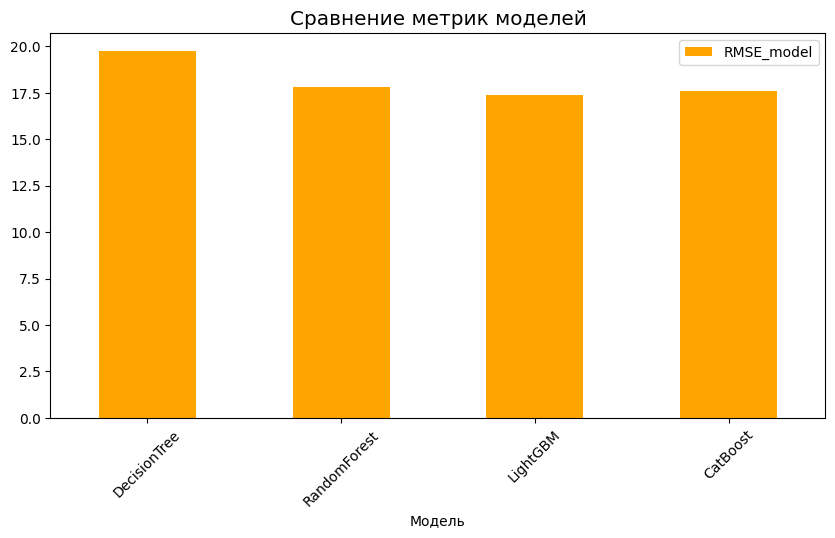

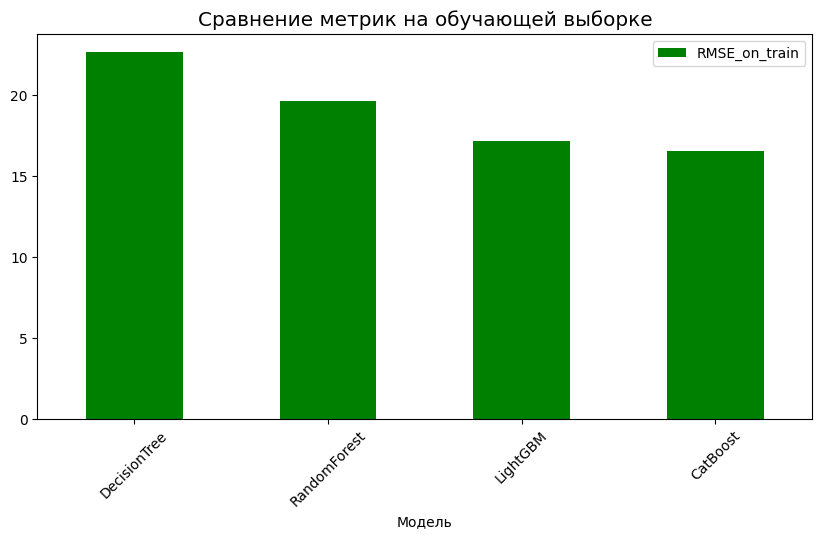

In [55]:
all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'LightGBM', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='RMSE_model', x='names', rot=45, figsize=(10,5), color='orange')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.plot.bar(y='RMSE_on_train', x='names', rot=45, figsize=(10,5), color='green')
plt.title('Сравнение метрик на обучающей выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

## Тестирование

In [56]:
predicted = lgbm_model.predict(test_X)
rmse_on_test = mean_squared_error(test_y, predicted, squared=False)
print('RMSE на тестовой выборке при использовании RandomizedSearchCV:', rmse_on_test)

RMSE на тестовой выборке при использовании RandomizedSearchCV: 43.39079269785423


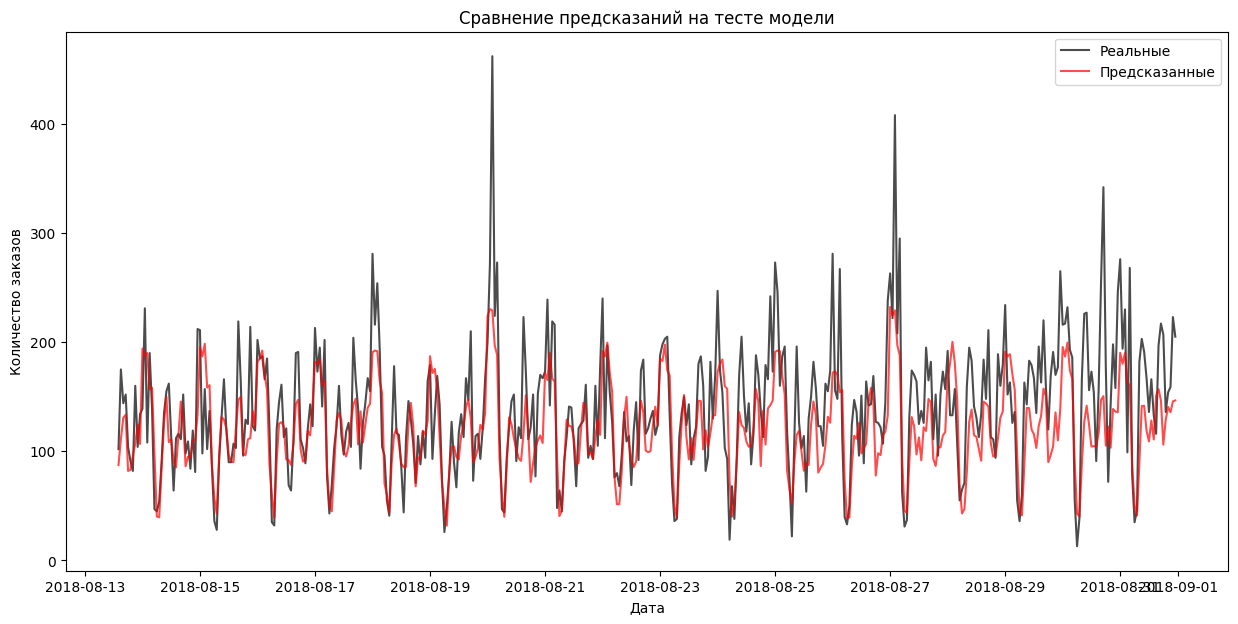

In [57]:
predicted = pd.DataFrame(predicted, index=test_X.index)

plt.figure(figsize=(15,7))
plt.plot(test_y, color='black', alpha=0.7)
plt.plot(predicted, color='red', alpha=0.7)
plt.title('Сравнение предсказаний на тесте модели')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

**Вывод:**

RMSE модели 43.5 - необходимое значение метрики получено, текущую модель LightGBM можно использовать.